In [ ]:
from sklearn.utils import shuffle  
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt 
import numpy as np 
import sklearn

from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.initializers import TruncatedNormal 
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense
import tensorflow as tf 
tf.config.experimental.list_physical_devices('GPU')

In [ ]:
test_data = pd.read_csv('original_test_data.csv')
test_data = test_data[['sentence','maslow']]
test_data.head(2)

,sentence,maslow
0,Jamies job requires her to travel a lot.She ha...,esteem
1,Andy was craving some cereal.He picked out som...,physiological


In [ ]:
test_data[['sentence','maslow']].groupby('maslow').count()

,sentence
maslow,
esteem,1038
love,900
none,509
physiological,455
spiritual growth,472
stability,745


In [ ]:
test_data_need_category = test_data[test_data['maslow']!='none']
test_data_need_category.shape[0]

3610

In [ ]:
t = test_data_need_category[400:800]
from google.colab import files

t.to_excel('test_data_need_category_set_3.xlsx')
files.download('test_data_need_category_set_3.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
t

,sentence,maslow
219,Phil got a job delivering newspapers on his bi...,need
220,The man tried on a fake mustache.He snuck up b...,need
221,A man wanted to increase his intelligence.He t...,need
222,Lane's dad had been in the army and he wanted ...,need
223,The man went fishing.He caught more than his l...,need
...,...,...
443,There lived a mercenary with no feelings or em...,need
444,Jackson wasn't feeling well to his stomach.His...,need
445,Julio wanted to impress the girl in his wilder...,need
446,Michael lost a tooth.,need


#### Merging

In [ ]:
annotated_needcat_test_data_1 = pd.read_excel("/content/test_data_need_category_set_1.xlsx")
annotated_needcat_test_data_2 = pd.read_excel('/content/test_data_need_category_set_2.xlsx')
annotated_needcat_test_data_3 = pd.read_excel('/content/test_data_need_category_set_3.xlsx')
annotated_needcat_test_data = pd.concat([annotated_needcat_test_data_1,annotated_needcat_test_data_2,annotated_needcat_test_data_3])
annotated_needcat_test_data = shuffle(annotated_needcat_test_data)
annotated_needcat_test_data['maslow'] = annotated_needcat_test_data['maslow'].replace(['physiological','love','stability','esteem','spiritual growth'],['need','need','need','need','need'])
annotated_needcat_test_data['our'] = annotated_needcat_test_data['our'].replace([0,1],['need','no need'])

In [ ]:
annotated_needcat_test_data.head()

,Unnamed: 0,sentence,maslow,our,annotator
180,197,Sam was a car dealer.He tried to sell a car to...,need,need,ajinkya
6,9,Lily was flying alone for the first time.,need,no need,ajinkya
88,318,Cassie's Mom packed her lunch and wave her off...,need,need,anish
148,163,Lucy and her mother were hunting for a movie t...,need,need,ajinkya
41,267,"My dog, Ninja, likes to run in our small yard....",need,need,anish


In [ ]:
annotated_needcat_test_data[['maslow','sentence','our','annotator']].groupby(['maslow','annotator','our']).count()

sentence
maslow annotator our              
need   ajinkya   need          176
                 no need        24
       anish     need          192
                 no need         8
       gurudeep  need          184
                 no need        15

In [ ]:
lb = LabelEncoder() 
annotated_needcat_test_data['maslowLabel'] = lb.fit_transform(annotated_needcat_test_data['maslow'])
annotated_needcat_test_data['ourlabel'] = lb.fit_transform(annotated_needcat_test_data['our']) 

In [ ]:
def make_confusion_matrix(cf,group_names=None,categories='auto',count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [ ]:
uniqueClassesMaslowLabel2 = list(annotated_needcat_test_data['maslow'].unique())
uniqueClassesMaslow2 = list(annotated_needcat_test_data['maslowLabel'].unique())
uniqueClassesMaslowLabel2 = ['need','no need']
uniqueClassesMaslow2 = [0,1]
print(uniqueClassesMaslowLabel2)
print(uniqueClassesMaslow2)

['need', 'no need']
[0, 1]


In [ ]:
integer_label = annotated_needcat_test_data['maslowLabel']
review_predictions2 = annotated_needcat_test_data['ourlabel']

[[552   0]
 [ 47   0]]


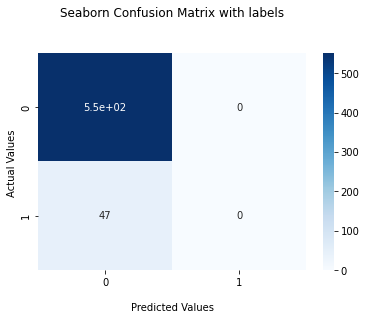

In [ ]:
from sklearn.metrics import confusion_matrix
r2 = confusion_matrix(review_predictions2, integer_label)
print(r2)
ax = sns.heatmap(r2, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in long_scalars


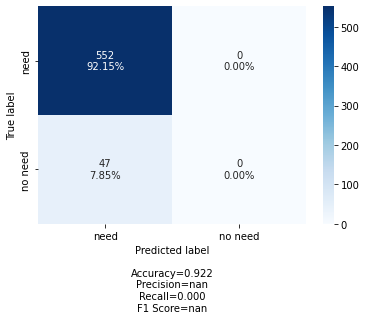

In [ ]:
make_confusion_matrix(r2, group_names=uniqueClassesMaslow2, categories=uniqueClassesMaslowLabel2, cmap='Blues')

#### BERT

https://www.youtube.com/watch?v=RgpANRh44ao

In [19]:
!pip install -q -U "tensorflow-text==2.8.*"
!pip install -q tf-models-official==2.7.0
!pip install text_hammer
!pip install transformers

     |████████████████████████████████| 4.9 MB 26.6 MB/s 
     |████████████████████████████████| 1.8 MB 34.6 MB/s 
     |████████████████████████████████| 1.3 MB 61.2 MB/s 
     |████████████████████████████████| 238 kB 71.3 MB/s 
     |████████████████████████████████| 352 kB 70.0 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 99 kB 11.3 MB/s 
     |████████████████████████████████| 116 kB 70.7 MB/s 
     |████████████████████████████████| 1.1 MB 62.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle  
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt 
import numpy as np 
import sklearn

from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.initializers import TruncatedNormal 
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense
import tensorflow as tf 
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
import keras
tf.get_logger().setLevel('ERROR')
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import warnings
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False 

In [49]:
df_train = pd.read_csv('original_train_data.csv')
df_test = pd.read_csv('original_test_data.csv')
df_test = df_test[df_test['maslow']!='none']
df_train = df_train[df_train['maslow']!='none']
df_test = df_test[['sentence','maslow']]
df_train = df_train[['sentence','maslow']]
df_train['maslow'] = df_train['maslow'].replace(['physiological','love','stability','esteem','spiritual growth'],['basic_needs','basic_needs','basic_needs','advanced_needs','advanced_needs'])
df_test['maslow'] = df_test['maslow'].replace(['physiological','love','stability','esteem','spiritual growth'],['basic_needs','basic_needs','basic_needs','advanced_needs','advanced_needs'])

In [50]:
from tqdm._tqdm_notebook import tqdm_notebook 
import text_hammer as th
tqdm_notebook.pandas()

def text_preprocessing(df, column_name):
    column = column_name 
    df[column] = df[column].progress_apply(lambda x:str(x).lower())
    df[column] = df[column].progress_apply(lambda x: th.cont_exp(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))
    return(df)
df_train = text_preprocessing(df_train,'sentence')
df_test = text_preprocessing(df_test,'sentence')

  0%|          | 0/14440 [00:00<?, ?it/s]

  0%|          | 0/14440 [00:00<?, ?it/s]

  0%|          | 0/14440 [00:00<?, ?it/s]

  0%|          | 0/14440 [00:00<?, ?it/s]

  0%|          | 0/14440 [00:00<?, ?it/s]

  0%|          | 0/14440 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

In [51]:
lb = LabelEncoder() 
df_train['maslowLabel'] = lb.fit_transform(df_train['maslow'])
df_test['maslowLabel'] = lb.fit_transform(df_test['maslow'])
print(df_train['maslow'].unique())
print(df_train['maslowLabel'].unique())
print(df_test['maslow'].unique())
print(df_test['maslowLabel'].unique())

['basic_needs' 'advanced_needs']
[1 0]


In [52]:
df_train[['sentence','maslow']].groupby('maslow').count()

,sentence
maslow,
advanced_needs,6037
basic_needs,8403


In [53]:
x_train_text = df_train['sentence']
y_train_text = df_train['maslow']
x_test_text = df_test['sentence']
y_test_text = df_test['maslow']

x_train = df_train['sentence']
y_train = df_train['maslowLabel']
x_test = df_test['sentence']
y_test = df_test['maslowLabel']
print(x_train.shape)
print(x_test.shape)

(14440,)
(3610,)


In [54]:
unique, counts = np.unique(y_train, return_counts=True)
result = np.column_stack((unique, counts)) 
print (result)

[[   0 6037]
 [   1 8403]]


In [55]:
unique, counts = np.unique(y_test, return_counts=True)
result = np.column_stack((unique, counts)) 
print (result)

[[   0 1510]
 [   1 2100]]


In [56]:
y_train = tf.keras.utils.to_categorical(y_train)
y_test =  tf.keras.utils.to_categorical(y_test)
y_train

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [57]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [58]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-768_A-12' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

bert_encoder = map_name_to_handle[bert_model_name]
bert_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {bert_encoder}')
print(f'Preprocess model auto-selected: {bert_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [59]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1")

In [60]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.CategoricalCrossentropy(name='categorical_cross_entropy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
      CategoricalAccuracy('balanced_accuracy')
] 

In [99]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)
l = tf.keras.layers.Dropout(0.6, name="dropout1")(outputs['pooled_output'])
l = tf.keras.layers.Dense(units = 128, activation = 'relu', kernel_initializer = 'he_uniform',name = 'layer1')(l)
l = tf.keras.layers.BatchNormalization()(l, training= True)

l = tf.keras.layers.Dropout(0.5, name="dropout2")(l)
l = tf.keras.layers.Dense(units = 128, activation = None, kernel_initializer = 'he_uniform',name = 'layer2')(l)
l = tf.keras.layers.BatchNormalization()(l, training= True)

l = tf.keras.layers.Dropout(0.6, name="dropout3")(l)
l = tf.keras.layers.Dense(units = 128, activation = None, kernel_initializer = 'he_uniform',name = 'layer3')(l)
l = tf.keras.layers.Dense(2, activation='softmax', name="output")(l)
model = tf.keras.Model(inputs=[text_input], outputs = [l])
optimizer = Adam(
    learning_rate = 5e-05,
    epsilon = 1e-08,
    decay = 0.01,
    clipnorm = 1.0
)
#loss = CategoricalCrossentropy() 
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True) , optimizer=optimizer, metrics=METRICS)

In [100]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_4 (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [102]:
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_balanced_accuracy',
    mode='max',
    save_best_only=True)

callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False,

)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_balanced_accuracy',
                                                 factor = 0.2,
                                                 patience = 1,
                                                 verbose = 1,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-7,
                                                 mode = 'max')          # Reduce learning rate when a metric has stopped improving.

# Model weights are saved at the end of every epoch, if it's the best seen
# so far.
# compile model
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True) , optimizer=optimizer, metrics=METRICS)
history = model.fit(x_train, y_train,epochs=20, verbose=1, validation_data = (x_test,y_test), batch_size  = 36,callbacks=[model_checkpoint_callback,callback, reduce_lr])

Epoch 1/20
402/402 [==============================] - 88s 211ms/step - loss: 1.4389 - tp: 8536.0000 - fp: 7884.0000 - tn: 8536.0000 - fn: 7884.0000 - categorical_cross_entropy: 1.3724 - precision: 0.5199 - recall: 0.5199 - auc: 0.5266 - prc: 0.5209 - balanced_accuracy: 0.5199 - val_loss: 0.9084 - val_tp: 2060.0000 - val_fp: 1550.0000 - val_tn: 2060.0000 - val_fn: 1550.0000 - val_categorical_cross_entropy: 0.9084 - val_precision: 0.5706 - val_recall: 0.5706 - val_auc: 0.5966 - val_prc: 0.5800 - val_balanced_accuracy: 0.5706 - lr: 1.0000e-07
Epoch 2/20
402/402 [==============================] - 83s 206ms/step - loss: 1.4038 - tp: 7551.0000 - fp: 6889.0000 - tn: 7551.0000 - fn: 6889.0000 - categorical_cross_entropy: 1.4038 - precision: 0.5229 - recall: 0.5229 - auc: 0.5318 - prc: 0.5253 - balanced_accuracy: 0.5229 - val_loss: 0.9084 - val_tp: 2060.0000 - val_fp: 1550.0000 - val_tn: 2060.0000 - val_fn: 1550.0000 - val_categorical_cross_entropy: 0.9084 - val_precision: 0.5706 - val_recall: 

In [72]:
y_test

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [73]:
model.load_weights(checkpoint_filepath)
model.evaluate(x_test, y_test)

113/113 [==============================] - 16s 143ms/step - loss: 0.6938 - tp: 2261.0000 - fp: 1349.0000 - tn: 2261.0000 - fn: 1349.0000 - categorical_cross_entropy: 0.6938 - precision: 0.6263 - recall: 0.6263 - auc: 0.6655 - prc: 0.6507 - balanced_accuracy: 0.6263


[0.6937503218650818,
 2261.0,
 1349.0,
 2261.0,
 1349.0,
 0.6937503218650818,
 0.6263157725334167,
 0.6263157725334167,
 0.6654703617095947,
 0.65070641040802,
 0.6263157725334167]

In [74]:
print(history.history.keys())

dict_keys(['loss', 'tp', 'fp', 'tn', 'fn', 'categorical_cross_entropy', 'precision', 'recall', 'auc', 'prc', 'balanced_accuracy', 'val_loss', 'val_tp', 'val_fp', 'val_tn', 'val_fn', 'val_categorical_cross_entropy', 'val_precision', 'val_recall', 'val_auc', 'val_prc', 'val_balanced_accuracy', 'lr'])


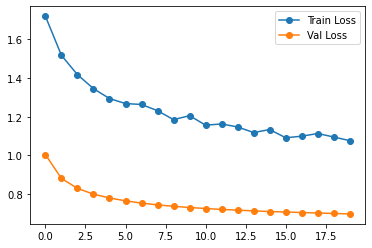

In [75]:
plt.plot(history.history['loss'], '-o', label='Train Loss')
plt.plot(history.history['val_loss'], '-o', label = 'Val Loss')
plt.legend()

In [76]:
y_pred2 = model.predict(x_test)

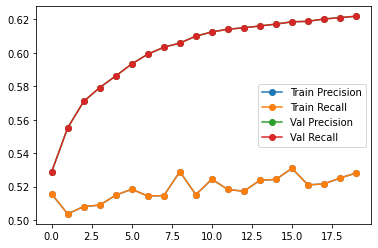

In [77]:
plt.plot(history.history['precision'], '-o', label='Train Precision')
plt.plot(history.history['recall'], '-o', label = 'Train Recall')
plt.plot(history.history['val_precision'], '-o', label='Val Precision')
plt.plot(history.history['val_recall'], '-o', label = 'Val Recall')
plt.legend()

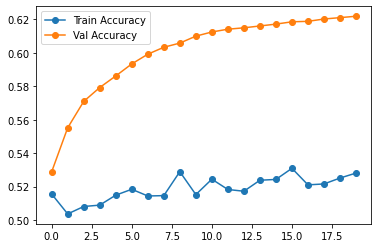

In [79]:
plt.plot(history.history['balanced_accuracy'], '-o', label='Train Accuracy')
plt.plot(history.history['val_balanced_accuracy'], '-o', label = 'Val Accuracy')
plt.legend()

In [80]:
y_pred2 = model.predict(x_test)

In [81]:
y_pred2[2]

array([0.45258948, 0.5474105 ], dtype=float32)

In [82]:
def get_predictions(y_pred2):
    review_predictions2 = []
    for prediction in y_pred2:
        x = prediction
        review_predictions2.append(np.argmax(x))

    review_predictions2 = np.array(review_predictions2)
    review_predictions2.reshape(1,-1)
    print(review_predictions2.shape)
    return review_predictions2

In [83]:
review_predictions2 = get_predictions(y_pred2)
review_predictions2

(3610,)


array([1, 1, 1, ..., 0, 0, 0])

In [84]:
k = pd.DataFrame(review_predictions2, columns = ['Label'])
k.groupby('Label')['Label'].count()

Label
0    1405
1    2205
Name: Label, dtype: int64

In [85]:
y_test_text

0       advanced_needs
1          basic_needs
2          basic_needs
3          basic_needs
4          basic_needs
             ...      
4112       basic_needs
4113       basic_needs
4114    advanced_needs
4115       basic_needs
4118       basic_needs
Name: maslow, Length: 3610, dtype: object

In [86]:
integer_label = df_test['maslowLabel']
integer_label = integer_label.reset_index(drop = True)
integer_label

0       0
1       1
2       1
3       1
4       1
       ..
3605    1
3606    1
3607    0
3608    1
3609    1
Name: maslowLabel, Length: 3610, dtype: int64

In [87]:
review_predictions2[:10]

array([1, 1, 1, 0, 1, 0, 1, 1, 1, 0])

In [89]:
from sklearn.metrics import classification_report
df_test.head()
uniqueClassesMaslowLabel2 = list(df_test['maslow'].unique())
uniqueClassesMaslow2 = list(df_test['maslowLabel'].unique())
uniqueClassesMaslowLabel2 = ['advanced_needs','basic_needs']
uniqueClassesMaslow2 = [0,1]
print(uniqueClassesMaslowLabel2)
print(uniqueClassesMaslow2)
print(classification_report(review_predictions2, integer_label,target_names = uniqueClassesMaslowLabel2))

['advanced_needs', 'basic_needs']
[0, 1]
                precision    recall  f1-score   support

advanced_needs       0.52      0.56      0.54      1405
   basic_needs       0.70      0.67      0.69      2205

      accuracy                           0.63      3610
     macro avg       0.61      0.61      0.61      3610
  weighted avg       0.63      0.63      0.63      3610



In [90]:
def make_confusion_matrix(cf,group_names=None,categories='auto',count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

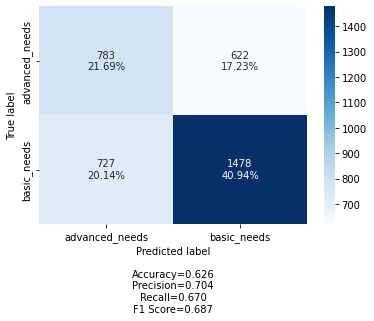

In [91]:
import matplotlib.pyplot as plt
r2 = sklearn.metrics.confusion_matrix(review_predictions2, integer_label)
number = [0,1]
category = ['advanced_needs','basic_needs']
make_confusion_matrix(r2, group_names=number, categories=category, cmap='Blues')

[[ 783  622]
 [ 727 1478]]


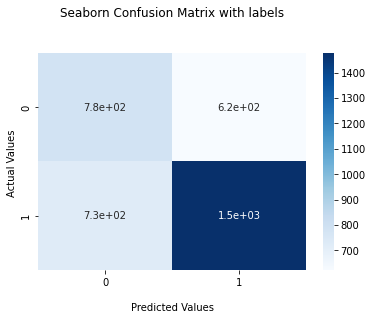

In [92]:
import seaborn as sns
r2 = sklearn.metrics.confusion_matrix(review_predictions2, integer_label)
print(r2)
ax = sns.heatmap(r2, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

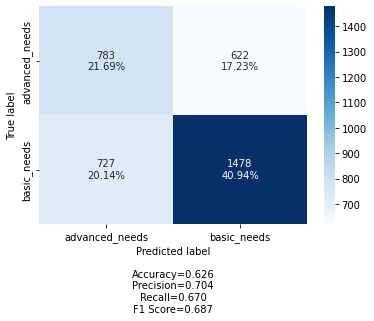

In [93]:
make_confusion_matrix(r2, group_names=uniqueClassesMaslow2, categories=uniqueClassesMaslowLabel2, cmap='Blues')

In [94]:
x_test_text = x_test_text.reset_index(drop = True)
x_test_text[0:5]

0    jamies job requires her to travel a lotshe has...
1    andy was craving some cerealhe picked out some...
2                                  karl locked his car
3    i was bullied in high schooli had one bully in...
4              kay was at work when a headache started
Name: sentence, dtype: object

In [95]:
def get_mistakes(prediction_values, actual_values, test_sentences, actual_category, predicted_category,samples_shown):
    # Make sure you Map uniqueClassesMaslowLabell2 catgory with the labels mapping as index. If label is 0 then the category index in the list should be 0
    count = 0
    correct_index = uniqueClassesMaslowLabel2.index(actual_category)
    incorrect_index = uniqueClassesMaslowLabel2.index(predicted_category)
    print('Text classified as ',uniqueClassesMaslowLabel2[incorrect_index]," but actual category is ",uniqueClassesMaslowLabel2[correct_index])
    for i in range(0,len(prediction_values)):
        if prediction_values[i] == incorrect_index and actual_values[i] == correct_index and count != samples_shown:
            print(str(i),test_sentences[i])
            count = count + 1

In [96]:
get_mistakes(prediction_values = review_predictions2,
             actual_values = integer_label,
             test_sentences = x_test_text,
             actual_category = 'advanced_needs', 
             predicted_category = 'basic_needs',
             samples_shown = 10)

Text classified as  basic_needs  but actual category is  advanced_needs
0 jamies job requires her to travel a lotshe has no family of her own so she does not mindher friends feel sorry for herthey think at her age she should have a familyshe promised herself to take her time with it and just be happy
6 lily was flying alone for the first time
8 dale just joined the car racing teamhe was allowed to drive for the first timehe blew everyones expectations out of the waterdale came close to making top three
14 in august billy is going overseas for the war
25 i was in the river fishing one dayat the bottom of the river i saw something glittery
28 amy and charles were going shopping for an engagement ringthey went to the mall and visited kay jewelersthey saw many rings within their price rangeamy finally saw the ring of her dreams
29 the magician pulled out a top hathe pulled some fabric out of the hat
30 dave had entered a raffle at work this past weekend
33 a carnival was coming to towndalt

#### Ignore

In [ ]:
texts = input(str('input the text '))
x_val = tokenizer(
    text = texts,  
    add_special_tokens = True,
    max_length = 70,
    truncation = True,
    padding = 'max_length',
    return_tensors = 'tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True
)
validation = model.predict({'input_ids':x_val['input_ids'], 'attention_mask':x_val['attention_mask']})*100 
validation

input the text I am tired


array([[37.3986  , 10.790863, 97.73828 , 36.55313 , 39.555515]],
      dtype=float32)

In [ ]:
for key, value in zip(encoded_dict.keys(), validation[0]):
    print(key, value)

esteem 37.3986
love 10.790863
physiological 97.73828
spiritual growth 36.55313
stability 39.555515


In [ ]:
reddit_data = pd.read_excel('reddit_data_with_predictions.xlsx')
reddit_data = reddit_data[['sentence']]

In [ ]:
df_cleaned = text_preprocessing(reddit_data,'sentence')

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

In [ ]:
df_cleaned['num_words'] = df_cleaned.sentence.apply(lambda x:len(x.split()))

In [ ]:
df_cleaned

,sentence,num_words
0,it feels like everyone else is passing me by a...,87
1,i do not know why but no matter what i do life...,79
2,recently i have been having obsessive thoughts...,417
3,he hides it from his friends whom he plays gam...,55
4,hello i have 22f struggled with my mental heal...,304
5,i fucked up and i need help apologizing to som...,70
6,i have just lost all my friends and i feel lik...,39
7,hello i am looking for support or just anyone ...,599
8,hey my friend has been struggling with a lot o...,69
9,everyday feels the same and i am distancing my...,136


In [ ]:
df_cleaned.num_words.max()

2608

In [ ]:
x_test = tokenizer(
    text = df_cleaned.sentence.tolist(),
    add_special_tokens = True,
    max_length = 70,
    truncation = True,
    padding = True, 
    return_tensors = 'tf',
    return_token_type_ids = False,
    return_attention_mask = True, 
    verbose = True
)
predicted_raw = model.predict({'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']}) 
predicted_raw[0]

array([0.49946058, 0.28485987, 0.04956754, 0.8316566 , 0.35192734],
      dtype=float32)

In [ ]:
predicted_raw[0][0]

0.49946058

In [ ]:
#y_predicted = np.argmax(predicted_raw[0])
#y_predicted
predicted_raw.shape

(49, 5)

In [ ]:
#'esteem':0, 'love':1,'physiological':2, 'spiritual growth':3, 'stability':4
category = ['esteem','love','physiological','spiritual growth','stability']
#category[y_predicted]

In [ ]:
df_cleaned.iloc[0][2]

'nan'

In [ ]:
predicted_raw[0][0]

0.49946058

In [ ]:
for i in category:
    df_cleaned[i] = 0

lis_esteem = []
lis_love = []
lis_physiological = []
lis_spiritual_growth = []
lis_stability = []

for i in range(len(predicted_raw)):
    lis_esteem.append(predicted_raw[i][0])
    lis_love.append(predicted_raw[i][1])
    lis_physiological.append(predicted_raw[i][2])
    lis_spiritual_growth.append(predicted_raw[i][3])
    lis_stability.append(predicted_raw[i][4])

df_cleaned['esteem'] = lis_esteem
df_cleaned['love'] = lis_love
df_cleaned['physiological'] = lis_physiological
df_cleaned['spiritual growth'] = lis_spiritual_growth
df_cleaned['stability'] = lis_stability
df_cleaned.head()

,sentence,num_words,esteem,love,physiological,spiritual growth,stability
0,it feels like everyone else is passing me by a...,87,0.499461,0.284860,0.049568,0.831657,0.351927
1,i do not know why but no matter what i do life...,79,0.308282,0.822921,0.173641,0.231122,0.290237
2,recently i have been having obsessive thoughts...,417,0.789368,0.185453,0.053224,0.683334,0.367675
3,he hides it from his friends whom he plays gam...,55,0.624000,0.583039,0.084634,0.422246,0.511769
4,hello i have 22f struggled with my mental heal...,304,0.477446,0.476595,0.095730,0.630944,0.310365


In [ ]:
from google.colab import files
df_cleaned.to_excel('reddit_data_with_predictions.xlsx')
files.download('reddit_data_with_predictions.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import zipfile

In [ ]:
!unzip file_location